https://www.kaggle.com/competitions/oxford-102-flower-pytorch

In [1]:
# import utils (models, ...)
from utils.custom_model_pytorch import NeuralNet
from utils.run_model_pytorch import RunModel

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import random
from skimage.io import imread
from sklearn.utils import class_weight
from collections import Counter
import time

In [3]:
# PyTorch libraries and modules
import torch
import torch.utils.data as data_utils
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d 
from torch.nn import Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, lr_scheduler

from torchvision import datasets, transforms, models

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# path dataset
path_train='flower_data/train/'
path_val='flower_data/valid/'
path_test='flower_data/test/'

In [6]:
# GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [7]:
num_cat=[]
for x in os.listdir(path_train):
    num_cat.append(x)
num_cat[0:5]

['27', '48', '69', '1', '10']

In [8]:
len(set(num_cat))

102

In [9]:
# Opening JSON file
f = open('flower_data/cat_to_name.json')
# json to dictionary
data_class = json.load(f)
# Closing file
f.close()

In [10]:
# dictionary classes
data_class['21']

'fire lily'

In [11]:
# make dataframe
train_folder_df=pd.DataFrame([data_class]).T
train_folder_df.columns=['class']

In [12]:
train_folder_df.head(3)

,class
21,fire lily
3,canterbury bells
45,bolero deep blue


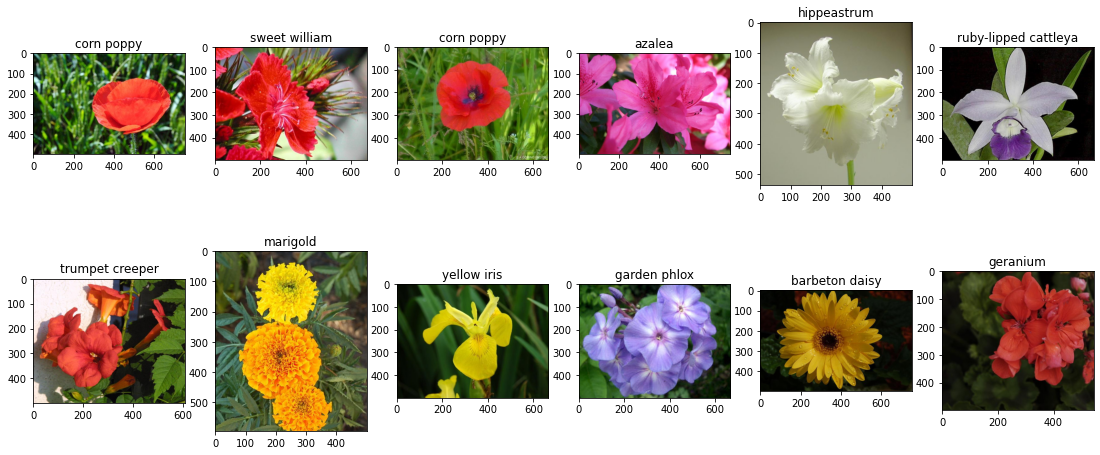

In [13]:
# plot some image examples
plt.figure(figsize = (19, 8))
i=1
for cl in range(12):
    im=train_folder_df.sample(n=1)
    ax=plt.subplot(2,6,i)
    path=path_train+im.index[0]+'/'
    #img = cv2.imread(path+random.choice(os.listdir(path)))
    img = imread(path+random.choice(os.listdir(path)))
    plt.imshow(img)
    plt.title(im['class'][0])
    i+=1
    

In [14]:
# counter (checking balance data classes)
counter={}
for i, row in train_folder_df.iterrows():
    count_={row[0]:len(os.listdir(path_train+i[0]))}
    counter.update(count_)
    
counter_df=pd.DataFrame([counter]).T.reset_index()  
counter_df.columns=['class','count']
counter_df['class_num']=train_folder_df.index
counter_df.head(3)

,class,count,class_num
0,fire lily,49,21
1,canterbury bells,36,3
2,bolero deep blue,44,45


In [15]:
# min max database flower class
counter_df.describe().T[['min', 'max']]

,min,max
count,27.0,70.0


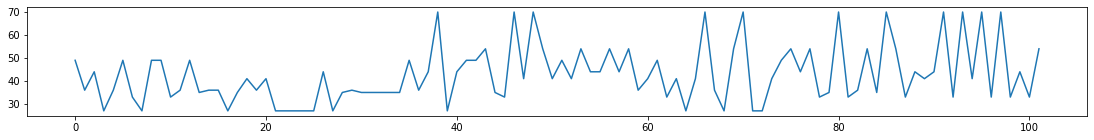

In [16]:
plt.figure(figsize = (19, 2))
plt.plot(counter_df.index, counter_df['count']);

## Convolutional Neural Network (CNN) PyTorch

In [17]:
# target_size
target_size = 32
# number of subprocesses data loading
num_workers = 4
# samples per batch to load
batch_size = 32
# percentage of training set to use as validation
#valid_size = 0.2

In [18]:
# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize(np.int(target_size*1.2)),
    transforms.RandomResizedCrop(target_size),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(np.int(target_size*1.2)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

In [19]:
# load and transform data using ImageFolder
train_data = datasets.ImageFolder(path_train, transform=train_transform)
val_data = datasets.ImageFolder(path_val, transform=test_transform)
test_data = datasets.ImageFolder(path_test, transform=test_transform)

In [20]:
train_data

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: flower_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=38, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [21]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

In [22]:
all_values_class=[]
for i, row in counter_df.iterrows():
    for j in range(row[1]):
        all_values_class.append(row[2])
len(all_values_class)

4360

In [23]:
# class_weight - Unbalanced Data                       
class_weights = class_weight.compute_class_weight('balanced', np.unique(all_values_class),all_values_class)
class_weights=torch.tensor(class_weights,dtype=torch.float)

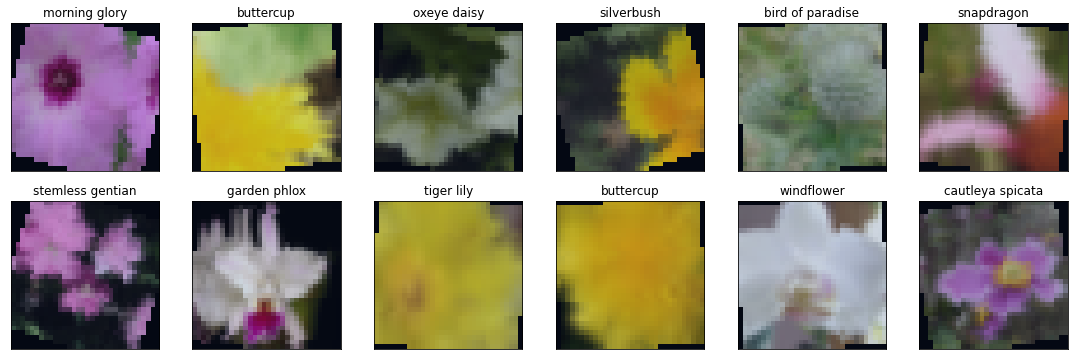

In [24]:
# visualize a batch of the train data loader

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
for i in np.arange(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title(data_class[str(labels[i].numpy())])

### Custom Model

In [25]:
# PyTorch CNN architecture
model = NeuralNet(len(set(num_cat)))
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
#print(model)

### Pre-trained VGG16 Model

In [26]:
# Load the pretrained model from pytorch
vgg19 = models.vgg19(pretrained=True, progress=False)

In [27]:
# print out the model structure
#print(vgg16)
print(vgg19.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [28]:
# Freeze training for all "features" layers
for param in vgg19.features.parameters():
    param.requires_grad = False

In [29]:
# Final Classifier Layer
n_inputs = vgg19.classifier[6].in_features
# new layers automatically have requires_grad = True
last_layer = Linear(n_inputs, len(set(num_cat)))
vgg19.classifier[6] = last_layer
# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg19.cuda()
# check last layer
#print(vgg16.classifier[6].out_features)
print(vgg19.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)


### Loss function

In [30]:
# loss function (categorical cross-entropy)
criterion = CrossEntropyLoss(weight=class_weights,reduction='mean')
# optimizer
optimizer = Adam(model.parameters(), lr=0.001)

from torch.optim import lr_scheduler
# step
step_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [31]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [32]:
# run model function 
runmodel=RunModel(vgg19, train_loader, valid_loader, criterion, optimizer, step_scheduler, n_epochs=20)
accuracies, losses = runmodel.run()

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 205/205 [02:07<00:00,  1.61batch/s, accuracy=1.02, loss=5.25]


Epoch: 1 | Train Loss: 5.246 | Accuracy: 1.058
Epoch: 1 | Valid Loss: 4.835 | Accuracy: 1.058
Validation loss decreased (inf --> 4.834595).  Saving model ...


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 205/205 [02:12<00:00,  1.55batch/s, accuracy=0.962, loss=5.24]


Epoch: 2 | Train Loss: 5.243 | Accuracy: 1.004
Epoch: 2 | Valid Loss: 4.831 | Accuracy: 1.004
Validation loss decreased (4.834595 --> 4.830947).  Saving model ...


  0%|                                                                                                                    | 0/205 [00:00<?, ?batch/s]

Epoch: 3 | Train Loss: 5.261 | Accuracy: 1.099
Epoch: 3 | Valid Loss: 4.833 | Accuracy: 1.099


  0%|                                                                                                                    | 0/205 [00:00<?, ?batch/s]

Epoch: 4 | Train Loss: 5.261 | Accuracy: 1.072
Epoch: 4 | Valid Loss: 4.831 | Accuracy: 1.072


  0%|                                                                                                                    | 0/205 [00:00<?, ?batch/s]

Epoch: 5 | Train Loss: 5.250 | Accuracy: 1.235
Epoch: 5 | Valid Loss: 4.833 | Accuracy: 1.235


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 205/205 [02:17<00:00,  1.50batch/s, accuracy=1.18, loss=5.27]


Epoch: 6 | Train Loss: 5.265 | Accuracy: 1.194
Epoch: 6 | Valid Loss: 4.831 | Accuracy: 1.194
Validation loss decreased (4.830947 --> 4.830749).  Saving model ...


  0%|                                                                                                                    | 0/205 [00:00<?, ?batch/s]

Epoch: 7 | Train Loss: 5.256 | Accuracy: 1.194
Epoch: 7 | Valid Loss: 4.831 | Accuracy: 1.194


  0%|                                                                                                                    | 0/205 [00:00<?, ?batch/s]

Epoch: 8 | Train Loss: 5.248 | Accuracy: 1.113
Epoch: 8 | Valid Loss: 4.831 | Accuracy: 1.113


  0%|                                                                                                                    | 0/205 [00:00<?, ?batch/s]

Epoch: 9 | Train Loss: 5.266 | Accuracy: 1.058
Epoch: 9 | Valid Loss: 4.835 | Accuracy: 1.058


Epoch 10:  63%|████████████████████████████████████████████▍                         | 130/205 [01:25<00:49,  1.52batch/s, accuracy=1.01, loss=3.34]


KeyboardInterrupt: 

In [ ]:
accuracies

In [ ]:
losses